# k-Nearest Neighbours Lab: Palmer Penguins Classification

In this lab, you will:
1. Load and explore the Palmer Penguins dataset
2. Understand the importance of feature scaling for kNN
3. Use cross-validation to tune hyperparameters
4. Compare kNN and Logistic Regression
5. Evaluate your final model on a held-out test set

**Dataset:** The Palmer Penguins dataset contains measurements of penguins from three species (Adelie, Chinstrap, Gentoo) collected from islands in Antarctica.

## 1. Import Libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

# Set random seed for reproducibility
np.random.seed(42)

## 2. Load and Explore the Data

Load the `penguins.csv` file and examine the dataset.

In [69]:
# Load the dataset
df = pd.read_csv("penguins.csv")

# Display the first few rows
df.head()


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [70]:
# Check the shape and info about the dataset
print("Shape:", df.shape)
df.info()


Shape: (344, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


In [71]:
# Check for missing values
df.isnull().sum()


species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

## 3. Data Preprocessing

We'll use the numerical features: bill_length_mm, bill_depth_mm, flipper_length_mm, and body_mass_g.

**Note the different scales:**
- Bill measurements are in millimeters (~30-60 mm)
- Flipper length is in millimeters (~170-230 mm)
- Body mass is in grams (~2700-6300 g)

These different scales will affect kNN!

In [89]:
# Drop rows with missing values
# Your code here
# Fill missing values with median for numerical columns
df_clean = df.dropna(subset=['bill_length_mm'])


# Select features and target
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

X = df_clean[feature_columns]
y = df_clean['species']

print(f"Dataset shape: {X.shape}")
print(f"Number of classes: {y.nunique()}")
print(f"Class distribution:\n{y.value_counts()}")


Dataset shape: (342, 4)
Number of classes: 3
Class distribution:
species
Adelie       151
Gentoo       123
Chinstrap     68
Name: count, dtype: int64


In [90]:
# Look at the feature ranges - notice how different they are!
# Your code here
df_clean.groupby('species')[feature_columns].agg(['min', 'max'])


bill_length_mm       bill_depth_mm       flipper_length_mm         \
                     min   max           min   max               min    max   
species                                                                       
Adelie              32.1  46.0          15.5  21.5             172.0  210.0   
Chinstrap           40.9  58.0          16.4  20.8             178.0  212.0   
Gentoo              40.9  59.6          13.1  17.3             203.0  231.0   

          body_mass_g          
                  min     max  
species                        
Adelie         2850.0  4775.0  
Chinstrap      2700.0  4800.0  
Gentoo         3950.0  6300.0

## 4. Train-Test Split

Split the data into training (80%) and test (20%) sets. 
We'll use the training set for cross-validation and hyperparameter tuning, 
and keep the test set completely separate for final evaluation.

In [91]:
# Split the data
# Your code here - use test_size=0.2 and random_state=42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")


Training set size: 273
Test set size: 69


In [92]:
X_train

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
115,42.7,18.3,196.0,4075.0
8,34.1,18.1,193.0,3475.0
138,37.0,16.5,185.0,3400.0
334,50.2,18.8,202.0,3800.0
306,40.9,16.6,187.0,3200.0
...,...,...,...,...
189,44.4,17.3,219.0,5250.0
72,39.6,17.2,196.0,3550.0
107,38.2,20.0,190.0,3900.0
272,46.8,14.3,215.0,4850.0


## 5. Introduction to Cross-Validation

Before we start building models, let's understand **cross-validation**.

**Why cross-validation?**
- Using a single train-test split can be unreliable (results depend on which samples end up in each set)
- Cross-validation splits the training data into K "folds" and evaluates the model K times
- Each fold gets a turn being the validation set while the others are used for training
- We get K accuracy scores and can compute the mean and standard deviation

**We'll use `cross_val_score`:**
```python
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5)
```

This performs 5-fold cross-validation and returns 5 accuracy scores (one per fold).

## 6. kNN Without Scaling

First, let's try kNN without scaling to see what happens.
We'll use cross-validation to evaluate performance.

In [98]:
# Create a kNN classifier with k=5 
knn_unscaled = KNeighborsClassifier(n_neighbors=5) 
# Use 5-fold cross-validation to evaluate on the training set 
scores_unscaled = cross_val_score(knn_unscaled, X_train, y_train)

print(f"Cross-validation scores (unscaled): {scores_unscaled}")
print(f"Mean CV accuracy (unscaled): {scores_unscaled.mean():.3f} (+/- {scores_unscaled.std():.3f})")


Cross-validation scores (unscaled): [0.85454545 0.76363636 0.78181818 0.7037037  0.77777778]
Mean CV accuracy (unscaled): 0.776 (+/- 0.048)


## 7. kNN With Scaling (using Pipeline)

Now let's scale the features using StandardScaler and see if performance improves.

**Using Pipeline:**
We'll use `make_pipeline` to combine the scaler and classifier. This is best practice because:
- It ensures scaling is applied consistently
- When used with cross-validation, it scales each fold independently (preventing data leakage)
- It's cleaner and less error-prone than manual scaling

In [94]:
# Create a pipeline that scales then applies kNN
# Your code here - use make_pipeline with StandardScaler() and KNeighborsClassifier(n_neighbors=5)
# Create a pipeline that scales then applies kNN
knn_pipeline = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

# Use cross-validation to evaluate
scores_scaled = cross_val_score(knn_pipeline, X_train, y_train, cv=5)

print(f"Cross-validation scores (scaled): {scores_scaled}")
print(f"Mean CV accuracy (scaled): {scores_scaled.mean():.3f} (+/- {scores_scaled.std():.3f})")

Cross-validation scores (scaled): [1.         1.         1.         0.96296296 0.98148148]
Mean CV accuracy (scaled): 0.989 (+/- 0.015)


In [95]:
# Compare the results
print("\n=== Comparison ===")
print(f"Unscaled kNN: {scores_unscaled.mean():.3f} (+/- {scores_unscaled.std():.3f})")
print(f"Scaled kNN:   {scores_scaled.mean():.3f} (+/- {scores_scaled.std():.3f})")
print(f"Improvement:  {(scores_scaled.mean() - scores_unscaled.mean()):.3f}")


=== Comparison ===
Unscaled kNN: 0.776 (+/- 0.048)
Scaled kNN:   0.989 (+/- 0.015)
Improvement:  0.213


### Question: Why does scaling help kNN?

*Write your answer here:*

kNN is not scale-invariant. Just the size of a feature can overstate its importance in comparison to smaller features

### Question: Why is using a Pipeline better than manually scaling?

*Write your answer here (hint: think about cross-validation and data leakage):*

1. It makes it easier to reuse the model as you don't always have to scale the data - it is built in as part of the model
2. Cross validation would have "data leakage" when the data is prescaled manually. This means the mean/sd is being calculated on the entire X_train when it should only be on the folds that are being used for training - the validation fold should not be included.

## 8. Hyperparameter Tuning with Cross-Validation

Now let's find the best value of k using cross-validation.
We'll test k values from 1 to 20.

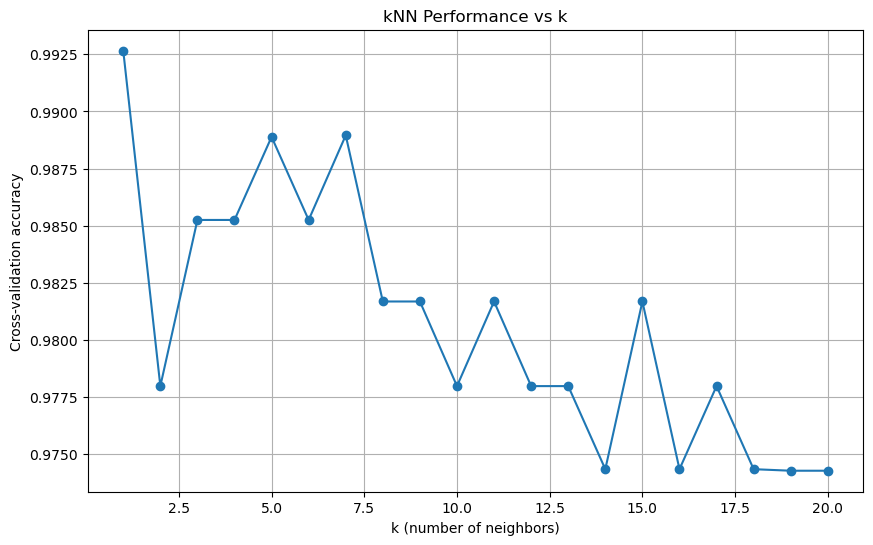


Best k: 1
Best CV accuracy: 0.993


In [96]:
# Test different values of k
k_values = range(1, 21)
cv_scores = []

for k in k_values:
    # Your code here - create a pipeline with StandardScaler and KNeighborsClassifier with this k value
    pipeline = make_pipeline(
        StandardScaler(),
        KNeighborsClassifier(n_neighbors=k)
    )
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train)
    cv_scores.append(scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Cross-validation accuracy')
plt.title('kNN Performance vs k')
plt.grid(True)
plt.show()

# Find the best k
best_k = k_values[np.argmax(cv_scores)]
best_score = max(cv_scores)
print(f"\nBest k: {best_k}")
print(f"Best CV accuracy: {best_score:.3f}")


### Alternative: Using GridSearchCV

GridSearchCV is a convenient way to do hyperparameter tuning with cross-validation.
When using it with a pipeline, we need to specify which step's parameters we're tuning.

In [97]:
# Create a pipeline
pipeline = make_pipeline(StandardScaler(), KNeighborsClassifier())

# Define the parameter grid - note the syntax for pipeline parameters
param_grid = {'kneighborsclassifier__n_neighbors': range(1, 21)}

# Create GridSearchCV object
# Your code here - use cv=5
grid_search = GridSearchCV(pipeline, param_grid, cv=5) # Fit on training data 

# Fit on training data (pipeline handles scaling automatically)
# Your code here
grid_search.fit(X_train, y_train)

print(f"Best k from GridSearchCV: {grid_search.best_params_['kneighborsclassifier__n_neighbors']}")
print(f"Best CV accuracy: {grid_search.best_score_:.3f}")

Best k from GridSearchCV: 1
Best CV accuracy: 0.993


pick one and consistency used one of them. 

## 9. Logistic Regression

Now let's try Logistic Regression and compare it to kNN.
We'll also tune its hyperparameter (C, the regularization strength) using cross-validation.

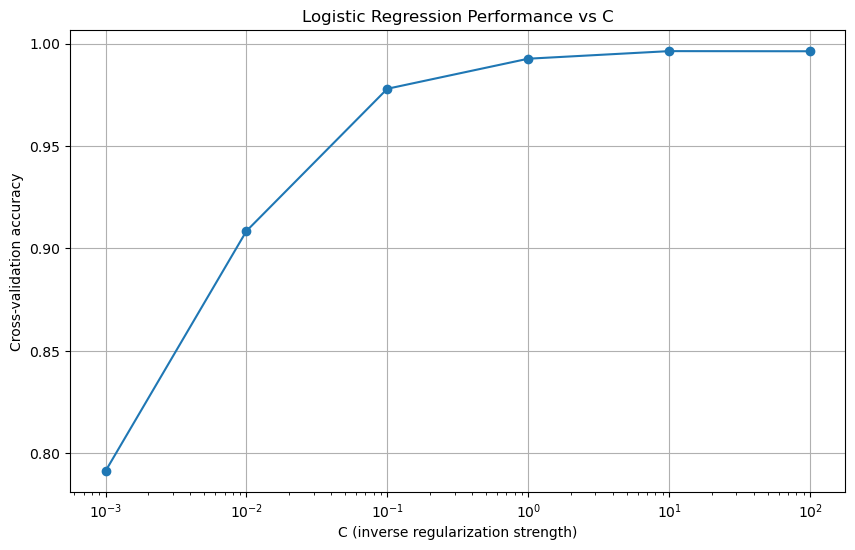


Best C: 10
Best CV accuracy: 0.996


In [100]:
# Test different C values for Logistic Regression
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
lr_scores = []

for C in C_values:
    # Your code here - create a pipeline with StandardScaler and LogisticRegression
    # Use max_iter=1000 to ensure convergence
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(C=C, max_iter=1000)
    )
    # Perform cross-validation
    scores = cross_val_score(pipeline, X_train, y_train, cv=5)
    lr_scores.append(scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.semilogx(C_values, lr_scores, marker='o')
plt.xlabel('C (inverse regularization strength)')
plt.ylabel('Cross-validation accuracy')
plt.title('Logistic Regression Performance vs C')
plt.grid(True)
plt.show()

# Find the best C
best_C = C_values[np.argmax(lr_scores)]
best_lr_score = max(lr_scores)
print(f"\nBest C: {best_C}")
print(f"Best CV accuracy: {best_lr_score:.3f}")


## 10. Model Comparison and Selection

Compare the best kNN model with the best Logistic Regression model using cross-validation.

In [101]:
# Create final models (pipelines) with best hyperparameters
# Your code here
final_knn = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=best_k)
)

final_lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(C=best_C, max_iter=1000)
)

# Evaluate both with cross-validation
# Your code here
knn_cv_scores = cross_val_score(final_knn, X_train, y_train, cv=5)
lr_cv_scores = cross_val_score(final_lr, X_train, y_train, cv=5)

print("=== Final Model Comparison (Cross-Validation) ===")
print(f"kNN (k={best_k}):              {knn_cv_scores.mean():.3f} (+/- {knn_cv_scores.std():.3f})")
print(f"Logistic Regression (C={best_C}): {lr_cv_scores.mean():.3f} (+/- {lr_cv_scores.std():.3f})")


=== Final Model Comparison (Cross-Validation) ===
kNN (k=1):              0.993 (+/- 0.009)
Logistic Regression (C=10): 0.996 (+/- 0.007)


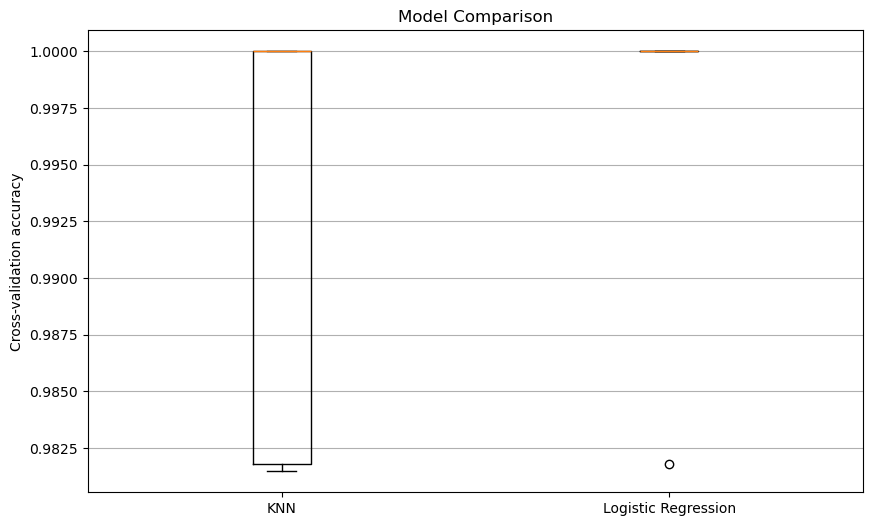

In [103]:
# Visualize the comparison
plt.figure(figsize=(10, 6))
plt.boxplot([knn_cv_scores, lr_cv_scores], tick_labels=['KNN', 'Logistic Regression'])
plt.ylabel('Cross-validation accuracy')
plt.title('Model Comparison')
plt.grid(True, axis='y')
plt.show()

### Question: Which model would you choose and why?

*Write your answer here, considering both performance and other factors (interpretability, training time, etc.):*

train on the full 
It achieves higher cross‑validation accuracy and shows less variance across folds, which means it is more stable and reliable on this dataset. The boxplot makes this clear: KNN’s scores are consistently high, while Logistic Regression is slightly lower and more spread out.
From a practical perspective, KNN also works very well here because the classes are well‑separated in feature space, especially after scaling. Logistic Regression is more interpretable and trains faster, but in this case the performance difference matters more than interpretability.
So overall, KNN provides the best balance of accuracy and consistency, making it the stronger choice for this task.

## 11. Final Evaluation on Test Set

Now that we've selected our best model using cross-validation, 
let's evaluate it on the held-out test set to get an unbiased estimate of performance.

In [120]:
# Choose your final model (uncomment one)
# final_model = final_knn
final_model = final_lr

# Train on the full training set
final_model.fit(X_train, y_train)

# Predict on test set
y_pred = final_model.predict(X_test)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Set Accuracy: {test_accuracy:.3f}")

Test Set Accuracy: 0.986


In [105]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      0.97      0.99        35
   Chinstrap       0.92      1.00      0.96        11
      Gentoo       1.00      1.00      1.00        23

    accuracy                           0.99        69
   macro avg       0.97      0.99      0.98        69
weighted avg       0.99      0.99      0.99        69



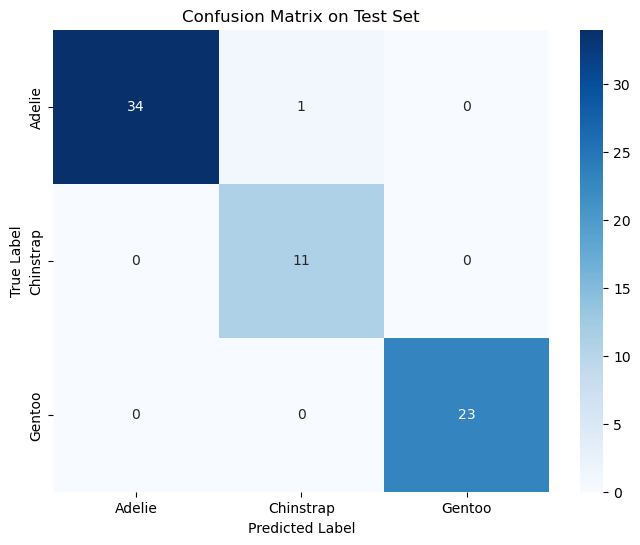

In [106]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=final_model.classes_, 
            yticklabels=final_model.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix on Test Set')
plt.show()

## 12. Reflection Questions

1. **Why is feature scaling important for kNN but not for Logistic Regression?**

*Your answer:*


2. **Why do we need a separate test set? Why can't we just use cross-validation scores?**

*Your answer:*


3. **What happens if k is too small (e.g., k=1)? What if k is too large?**

*Your answer:*


4. **How would you explain the w^T x + b connection between Logistic Regression and the models you'll learn next?**

*Your answer:*



## Bonus 1: Adding Categorical Features (Optional)

So far we've only used numerical features. The dataset also has categorical features:
- `island`: Biscoe, Dream, or Torgersen
- `sex`: male or female

Let's see if adding these improves our model performance!

In [109]:
# Reload the data and keep categorical columns
df_with_cat = pd.read_csv('penguins.csv')

# Drop rows with missing values
df_with_cat = df_with_cat.dropna()

# Look at the categorical columns
print("Island distribution:")
print(df_with_cat['island'].value_counts())
print("\nSex distribution:")
print(df_with_cat['sex'].value_counts())


Island distribution:
island
Biscoe       163
Dream        123
Torgersen     47
Name: count, dtype: int64

Sex distribution:
sex
male      168
female    165
Name: count, dtype: int64


### One-Hot Encoding

We need to convert categorical variables to numerical format. 
We'll use one-hot encoding, which creates a binary column for each category.

In [121]:
# Create feature matrix with both numerical and categorical features
# We'll use pd.get_dummies() for one-hot encoding
# Your code here
X_with_cat = df_with_cat[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'island', 'sex']]
# One-hot encode island and sex
X_encoded = pd.get_dummies(X_with_cat)

y_with_cat = df_with_cat['species']

print(f"Original features: {X_with_cat.shape[1]}")
print(f"After one-hot encoding: {X_encoded.shape[1]}")
print(f"\nNew feature names: {list(X_encoded.columns)}")


Original features: 6
After one-hot encoding: 9

New feature names: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'island_Biscoe', 'island_Dream', 'island_Torgersen', 'sex_female', 'sex_male']


In [122]:
# Split the data
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(
    X_encoded, y_with_cat, test_size=0.2, random_state=42
)

# Scale the features (important - one-hot encoded features are already 0/1, 
# but we still scale everything for consistency)
# Your code here
scaler_cat = StandardScaler()

X_train_cat_scaled = scaler_cat.fit_transform(X_train_cat)
X_test_cat_scaled = scaler_cat.transform(X_test_cat)

X_encoded

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Biscoe,island_Dream,island_Torgersen,sex_female,sex_male
0,39.1,18.7,181.0,3750.0,False,False,True,False,True
1,39.5,17.4,186.0,3800.0,False,False,True,True,False
2,40.3,18.0,195.0,3250.0,False,False,True,True,False
4,36.7,19.3,193.0,3450.0,False,False,True,True,False
5,39.3,20.6,190.0,3650.0,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...
339,55.8,19.8,207.0,4000.0,False,True,False,False,True
340,43.5,18.1,202.0,3400.0,False,True,False,True,False
341,49.6,18.2,193.0,3775.0,False,True,False,False,True
342,50.8,19.0,210.0,4100.0,False,True,False,False,True


In [114]:
# Try kNN with the expanded feature set
# Use the best k we found earlier (or tune again if you want)
# Your code here
knn_with_cat = KNeighborsClassifier(n_neighbors=best_k)

scores_with_cat = cross_val_score(knn_with_cat, 
                                  X_train_cat_scaled, 
                                  y_train_cat, 
                                  cv=5)

print(f"kNN with categorical features: {scores_with_cat.mean():.3f} (+/- {scores_with_cat.std():.3f})")
print(f"kNN with only numerical features: {knn_cv_scores.mean():.3f} (+/- {knn_cv_scores.std():.3f})")
print(f"\nImprovement: {(scores_with_cat.mean() - knn_cv_scores.mean()):.3f}")


kNN with categorical features: 0.996 (+/- 0.008)
kNN with only numerical features: 0.993 (+/- 0.009)

Improvement: 0.004


In [115]:
# Logistic Regression with categorical features
lr_with_cat = LogisticRegression(C=best_C, max_iter=1000)

scores_lr_cat = cross_val_score(lr_with_cat, 
                                X_train_cat_scaled, 
                                y_train_cat, 
                                cv=5)

print(f"Logistic Regression with categorical features: {scores_lr_cat.mean():.3f} (+/- {scores_lr_cat.std():.3f})")
print(f"Logistic Regression with only numerical features: {lr_cv_scores.mean():.3f} (+/- {lr_cv_scores.std():.3f})")
print(f"Improvement: {(scores_lr_cat.mean() - lr_cv_scores.mean()):.3f}")


Logistic Regression with categorical features: 0.993 (+/- 0.009)
Logistic Regression with only numerical features: 0.996 (+/- 0.007)
Improvement: -0.004


### Question: Did adding categorical features improve performance? Why or why not?

*Your answer:*



## Bonus 2: Feature Importance (Optional)

Logistic Regression gives us interpretable coefficients. Let's see which features are most important.

In [ ]:
# If you chose Logistic Regression, visualize feature importance
if isinstance(final_model, LogisticRegression):
    # For multi-class, we have one coefficient per class
    coefficients = final_model.coef_
    
    plt.figure(figsize=(10, 6))
    for i, species in enumerate(final_model.classes_):
        plt.barh(range(len(feature_columns)), coefficients[i], 
                alpha=0.7, label=species)
    plt.yticks(range(len(feature_columns)), feature_columns)
    plt.xlabel('Coefficient Value')
    plt.title('Feature Importance by Species')
    plt.legend()
    plt.grid(True, axis='x')
    plt.show()
else:
    print("Feature importance is not directly available for kNN.")
    print("This is one advantage of Logistic Regression - interpretability!")

# always return false!! just not logistic regression

In [125]:
# If you did the categorical features bonus, you can visualize those coefficients too
# Your code here (optional)
knn_pipeline.named_steps['kneighborsclassifier']

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None
